In [1]:
%config IPCompleter.use_jedi=False
import pandas as pd
import numpy as np
import math
from datetime import datetime
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, History, TensorBoard, Callback, LearningRateScheduler
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, RepeatVector
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
import seaborn as sns

# plt.style.use('seaborn')
plt.style.use('fivethirtyeight')

In [2]:
data_total = pd.read_csv('Data_diario/diario_total_2016-2020.csv', sep=",")
data = data_total[['fecha','emisionesCo2_tCO2', 'bret_valor_usd', 'demanda', 'pbi_valor_millones','precio_total']]
data = data.set_index('fecha')
features = data.columns

In [3]:
features.shape

(5,)

In [4]:
# escalar - normalizar los datos
scaler= MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

In [5]:
data_scaled.shape

(1827, 5)

In [6]:
target_precio= data_total['precio_total'].values
target_precio= target_precio.reshape(-1,1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target_precio)

In [7]:
target_precio.shape, data_scaled.shape

((1827, 1), (1827, 5))

In [8]:
timesteps = 365 # dias (tiempo) del pasado que se usa para predecir
future_steps = 10 # instante de tiempo del futuro que se quiere predecir (=0 dia actual)


X = []
y = []


for i in range(timesteps, len(data_scaled) - future_steps):
    xi = [data_scaled[i - timesteps + j] for j in range(timesteps)]
    yi = target_scaled[i+future_steps] # target
    if not np.isnan(yi) and not np.any(np.isnan(xi)):
        X.append(xi)
        y.append(yi)

X = np.array(X)
y = np.array(y)

In [9]:
new_model = tf.keras.models.load_model('Modelos_entrenados/lstm_h5/lstm_2016_2020.h5')

In [10]:
new_predictions = new_model.predict(X)

46/46 [==============================] - 5s 92ms/step


In [11]:
new_predictions

array([[0.8365672 ],
       [0.84149396],
       [0.8687832 ],
       ...,
       [0.37628752],
       [0.37660325],
       [0.37821782]], dtype=float32)

In [12]:
new_predictions.shape

(1452, 1)

In [13]:
new_predictions= target_scaler.inverse_transform(new_predictions)
y = new_predictions.reshape(-1)
y.shape

(1452,)

In [14]:
df_past = data_total[['fecha', 'precio_total']]
df_past.fecha = pd.to_datetime(df_past.fecha, format="%Y-%m-%d")
df_past.rename(columns={'index': 'fecha', 'precio_total': 'Actual'}, inplace=True)

df_past

C:\Users\Romina\AppData\Local\Temp\ipykernel_14224\1096220400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.fecha = pd.to_datetime(df_past.fecha, format="%Y-%m-%d")
C:\Users\Romina\AppData\Local\Temp\ipykernel_14224\1096220400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.rename(columns={'index': 'fecha', 'precio_total': 'Actual'}, inplace=True)


,fecha,Actual
0,2016-01-01,47.42
1,2016-01-02,47.42
2,2016-01-03,47.42
3,2016-01-04,47.42
4,2016-01-05,47.42
...,...,...
1822,2020-12-27,49.02
1823,2020-12-28,49.02
1824,2020-12-29,49.02
1825,2020-12-30,49.02


In [15]:
# df_future = pd.DataFrame(columns=['fecha', 'Actual', 'Forecast'])
start_date= (df_past['fecha'] + pd.Timedelta(days=timesteps + future_steps)).iloc[0]
# start_date= df_past['fecha'].iloc[0]
end_date= df_past['fecha'].iloc[-1]

df_future= pd.DataFrame(
    columns=[
        "fecha",
        "Forecast", 
     ],)

df_future['fecha'] = pd.date_range(start_date, end_date)
df_future['Forecast'] = y.flatten()


results = df_pbi_deuda = (pd.merge(df_past, df_future, on='fecha', how='left'))
results.fillna(0, inplace=True)
results

,fecha,Actual,Forecast
0,2016-01-01,47.42,0.000000
1,2016-01-02,47.42,0.000000
2,2016-01-03,47.42,0.000000
3,2016-01-04,47.42,0.000000
4,2016-01-05,47.42,0.000000
...,...,...,...
1822,2020-12-27,49.02,46.314873
1823,2020-12-28,49.02,46.459297
1824,2020-12-29,49.02,46.492512
1825,2020-12-30,49.02,46.510296


In [16]:
results.to_csv('Data_diario/load_predict_2016-2020_10days.csv', index=False)

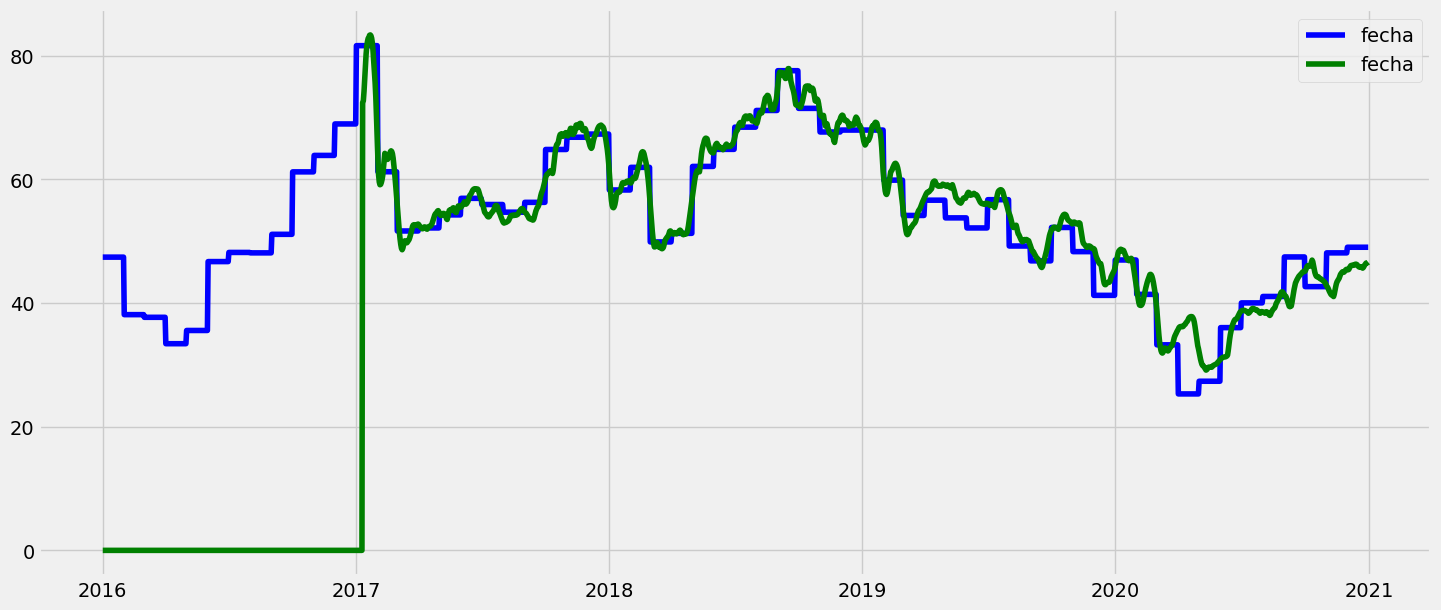

In [17]:
plt.figure(figsize=(16,7))
plt.plot(results['fecha'], results['Actual'],color='blue', label='fecha')
plt.plot(results['fecha'], results['Forecast'],color='green', label='fecha')
plt.legend()

# Metricas

In [18]:
# MSE
testScore = math.sqrt(mean_squared_error(results['Actual'], results['Forecast']))
print('Resultado del test: %.2f MSE' % (testScore))

Resultado del test: 23.10 MSE


In [19]:
r2Score_test= r2_score(results['Actual'], results['Forecast'])
print('Resultado del test: %.2f R2_SCORE' % (r2Score_test))

Resultado del test: -2.65 R2_SCORE


In [20]:
# mae
mae_test = mean_absolute_error(results['Actual'], results['Forecast'])
print('Resultado del test: %.2f MAE' % (mae_test))

Resultado del test: 11.78 MAE


In [21]:
new_predictions

array([[72.41547 ],
       [72.69294 ],
       [74.22987 ],
       ...,
       [46.49251 ],
       [46.510296],
       [46.601227]], dtype=float32)